In [1]:
import pandas as pd
import pickle
from pathlib import Path
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import networkx as nx
from scipy import sparse
import numpy as np
import random
import scipy
from tqdm import tqdm_notebook

# Utils

In [18]:
################# DAGS generating function ############################
def generate_dags(G, df):
    '''
    generates dags from a graph and propagation df
    considering all nodes that have previously activated
    '''
    df = df.sort_values(by=['time'])
    df['time'] = np.arange(len(df))
    for item in df.item.unique():
        node2time = dict(df[df.item == item][['node', 'time']].values)
        dag_edges = [
            (u, v)
            for u, v in G.edges
            if node2time.get(u, np.inf) < node2time.get(v, 0)
        ]
        dag = nx.DiGraph()
        dag.add_nodes_from(node2time.keys())
        dag.add_edges_from(dag_edges)
        yield dag

#######################################################################



################# DAG metrics #########################################
def branching_factor(dag):
    return list(dict(dag.out_degree()).values())

def len_path_dag(dag):
    return max(
            (dist
                for source, target2dist in nx.shortest_path_length(dag)
                for target, dist in target2dist.items()
                if np.isfinite(dist)
             ), default=np.nan)

#######################################################################

# Simulations

In [19]:
topics = 5
docs = 1
H = .5

#digg_complete_path = 'data/digg_friends_edgelist.nx'
#G =  nx.read_edgelist(digg_complete_path, create_using=nx.DiGraph, nodetype=int)
#G = nx.scale_free_graph(nodes_numb)
#G = nx.barabasi_albert_graph(nodes_numb, 5)
#digg_path = '/Users/Cinus/Work/Progetti/WoMG/WoMG/data/graph/digg/digg_graph_filtered.csv'
#G =  nx.read_edgelist(digg_path, create_using=nx.DiGraph, nodetype=int)
high_clust_graph_path = '/Users/Cinus/Work/Progetti/WoMG/WoMG/data/graph/digg/graph-highclust.nx'
G =  nx.read_edgelist(high_clust_graph_path, create_using=nx.DiGraph, nodetype=int)
nodes_numb = G.number_of_nodes()
seed = 4
virality_exp = 10
gn_strh = 2.5

In [20]:
# interests
from sklearn.decomposition import NMF
def nmf_emb(G, dimensions, seed, H):
    A = nx.adjacency_matrix(G)
    S_0 = overlap_generator(A)
    R = np.random.rand(G.number_of_nodes(), G.number_of_nodes())
    #S = beta*(S_0 + A + sparse.identity(A.shape[0])) + (1-beta)*R
    eta = 64.
    beta = 16 - 15.875*H
    S = eta*S_0 + A + beta*R
    model = NMF(n_components=dimensions, init='nndsvd', random_state=seed)
    W = model.fit_transform(S)
    return W
def overlap_generator(A):
    """
    Generate the second order overlap from a sparse adjacency matrix A.
    """
    aat = A.dot(A.T)
    d = aat.diagonal()
    ndiag = sparse.diags(d, 0)
    n = np.sqrt(ndiag.dot(aat>0).dot(ndiag))
    n.data[:] = 1./n.data[:]
    return aat.multiply(n) #- sparse.identity(aat.shape[0])

In [25]:
topics = 10
docs = 10

# items description
alpha =  [1. / topics for i in range(topics)]
gammas = {}
for item in range(docs):
    gammas[item] = np.random.dirichlet(alpha)
    gammas[item] /= np.linalg.norm(gammas[item])
    #print(np.linalg.norm(gammas[item]))
df_gammas = pd.DataFrame(gammas)

print('item 0 description: ', np.array(df_gammas[0]))

item 0 description:  [1.12400014e-05 2.03282630e-02 2.12378364e-08 2.06363608e-05
 9.99793334e-01 3.05248074e-06 2.23434252e-04 2.14743178e-05
 2.34710198e-05 1.96231014e-09]


In [26]:
print(scipy.stats.powerlaw.rvs(15, size=docs))

[0.93059361 0.97883759 0.98232079 0.97130299 0.99227033 0.9409851
 0.99806569 0.98250297 0.94491957 0.95008515]


In [27]:
assert len(G.nodes()) == nodes_numb

In [28]:
cascade_sizes = []
thresholds = []
homophilies = []
viralities = []
times = []
items = []
nodes = []


#### parameters
H = 1.
T = 10
threshold = .87
gn_stregth = 1
infl_strength = 15.



for H in tqdm_notebook([0., .25, .5, .75, 1.]):
    #### interests
    W = nmf_emb(G, topics, seed, H)
    
    for i in range(len(W)):
        W[i]/= np.linalg.norm(W[i])
    #print('average interest:',  np.mean([ np.array(df_gammas[0]).dot(W[node]) for node in range(nodes_numb) ]) )
    
    for virality in [0.5, 1, 2, 3]:
        for i, threshold in enumerate(scipy.stats.powerlaw.rvs(virality, size=docs)):
            print('homophily: ', H)
            print('threshold: ', threshold)
            #### fitness
            fitness = []
            if infl_strength == 0:
                fitness = np.zeros(nodes_numb)
            else:
                #fitness = np.random.pareto(a=infl_strength, size=nodes_numb) # ho tolto 1+
                fitness = scipy.stats.powerlaw.rvs(0.05, size=nodes_numb)
                if np.any(np.isinf(fitness)):
                    print('Wrong parameter infl strength')
                fitness = np.minimum(fitness, 10E20)
            print('fitness mean: ', np.mean(fitness))


            #### updated adjacency matrix
            A_prime = [[] for _ in range(nodes_numb)]

            for influencer in range(nodes_numb):
                for receiver in range(nodes_numb):
                    #print(influencer, receiver)
                    weight = np.array(df_gammas[i]).dot(fitness[influencer]*W[influencer]+W[receiver]) if (
                                        G.has_edge(influencer, receiver)) else 0
                    if receiver == influencer:
                        weight = 1
                    A_prime[influencer].append(weight)

            #### threshold map
            def z(x, threshold):
                return np.array([x[i]>threshold for i in range(len(x))])

            #### Diffusion

            a = [ [] for _ in range(T)]

            for t in tqdm_notebook(range(T)):
                if t==0:
                    interests_nodes = [ np.array(df_gammas[i]).dot(W[node]) for node in range(nodes_numb) ]
                    a[0] = z(gn_stregth*np.array(interests_nodes), threshold)
                    #print(np.diag(P))
                    print('initial actives: ', a[0].sum(), '/', nodes_numb)
                else:
                    a[t] = z((a[t-1]).dot(A_prime), threshold)
                    #print((A[t-1]).dot(P))
                    print(a[t].sum())
                    if np.array_equal(a[t], a[t-1]):
                        break

                for nod, act in enumerate(a[t]):

                    if len(a[t])!=0 and act:
                        times.append(t)
                        items.append(i)
                        nodes.append(nod)


            norms = [np.sum(x) for x in a if len(x)!=0]
            cascade_sizes.append(norms[-1])
            thresholds.append(threshold)
            homophilies.append(H)
            viralities.append(virality)


/Users/Cinus/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


homophily:  0.0
threshold:  0.011470157833016742
fitness mean:  0.044040319029582296


/Users/Cinus/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


initial actives:  476 / 500
494
495
495
homophily:  0.0
threshold:  0.0437459220143853
fitness mean:  0.04075028909287665



initial actives:  484 / 500
499
499
homophily:  0.0
threshold:  0.04304099468479437
fitness mean:  0.03620952349303755


initial actives:  430 / 500
470
470
homophily:  0.0
threshold:  0.3901974937314795
fitness mean:  0.04457081791047774




initial actives:  234 / 500
410
470
478
480
480
homophily:  0.0
threshold:  0.9322732333129198
fitness mean:  0.05281656414174833


initial actives:  0 / 500
0
homophily:  0.0
threshold:  0.08571588271849231
fitness mean:  0.046606395742236885




initial actives:  493 / 500
499
499
homophily:  0.0
threshold:  0.02886003588873306
fitness mean:  0.049746010828761345


initial actives:  499 / 500
500
500
homophily:  0.0
threshold:  0.2766304023578222
fitness mean:  0.03468944260968083




initial actives:  371 / 500
483
491
491
homophily:  0.0
threshold:  0.6187715600264623
fitness mean:  0.0486484542674014


initial actives:  51 / 500
189
399
453
457
457
homophily:  0.0
threshold:  0.2451637610636028
fitness mean:  0.05497413898160443




initial actives:  103 / 500
184
244
275
278
278
homophily:  0.0
threshold:  0.7763596721927204
fitness mean:  0.052699731154462554


initial actives:  7 / 500
8
8
homophily:  0.0
threshold:  0.4119203451379738
fitness mean:  0.05088565476582178




initial actives:  177 / 500
339
449
465
468
468
homophily:  0.0
threshold:  0.37110228893483144
fitness mean:  0.045793948434628716


initial actives:  123 / 500
189
215
226
231
231
homophily:  0.0
threshold:  0.2107142512649104
fitness mean:  0.04657672144395372




initial actives:  411 / 500
495
497
497
homophily:  0.0
threshold:  0.7211078268179653
fitness mean:  0.03716993689142192


initial actives:  11 / 500
15
15
homophily:  0.0
threshold:  0.311766119821947
fitness mean:  0.05114718391603218



initial actives:  387 / 500
484
491
493
495
495
homophily:  0.0
threshold:  0.837056866797479
fitness mean:  0.04808088544268507


initial actives:  6 / 500
7
7
homophily:  0.0
threshold:  0.4855049052802497
fitness mean:  0.045720572534595806




initial actives:  151 / 500
335
454
482
484
484
homophily:  0.0
threshold:  0.9434183940517853
fitness mean:  0.04616520870580603


initial actives:  0 / 500
0
homophily:  0.0
threshold:  0.10702642496915127
fitness mean:  0.04074513707608264




initial actives:  355 / 500
461
471
471
homophily:  0.0
threshold:  0.896770123511253
fitness mean:  0.047105867044901814


initial actives:  1 / 500
1
homophily:  0.0
threshold:  0.6651950867161077
fitness mean:  0.049859849700544794




initial actives:  20 / 500
34
34
homophily:  0.0
threshold:  0.7880513174506917
fitness mean:  0.043744606807283405


initial actives:  2 / 500
2
homophily:  0.0
threshold:  0.7401065055057805
fitness mean:  0.03894493188061571




initial actives:  5 / 500
5
homophily:  0.0
threshold:  0.3200797828815829
fitness mean:  0.05668296790331227


initial actives:  266 / 500
430
473
478
478
homophily:  0.0
threshold:  0.923672164508602
fitness mean:  0.04623918713097025




initial actives:  0 / 500
0
homophily:  0.0
threshold:  0.40242373550726596
fitness mean:  0.04774024563579174


initial actives:  338 / 500
482
492
492
homophily:  0.0
threshold:  0.9097956562846903
fitness mean:  0.055953110398219




initial actives:  0 / 500
0
homophily:  0.0
threshold:  0.5810886004001857
fitness mean:  0.051587659070781444


initial actives:  66 / 500
242
427
460
461
461
homophily:  0.0
threshold:  0.7447505043243352
fitness mean:  0.046682149247320955




initial actives:  5 / 500
5
homophily:  0.0
threshold:  0.6883479093080889
fitness mean:  0.04034114297140422


initial actives:  12 / 500
16
16
homophily:  0.0
threshold:  0.9977192124452942
fitness mean:  0.05312261288336927




initial actives:  0 / 500
0
homophily:  0.0
threshold:  0.8619785680913992
fitness mean:  0.06178899090594851


initial actives:  1 / 500
1
homophily:  0.0
threshold:  0.5300345133261861
fitness mean:  0.04239010038231377




initial actives:  83 / 500
123
131
132
133
133
homophily:  0.0
threshold:  0.8970807768849504
fitness mean:  0.04510982615165917


initial actives:  1 / 500
1
homophily:  0.0
threshold:  0.7265467037297753
fitness mean:  0.04100659405049644




initial actives:  12 / 500
13
13
homophily:  0.0
threshold:  0.42299991414210264
fitness mean:  0.04709911989104277


initial actives:  316 / 500
468
489
492
492
homophily:  0.0
threshold:  0.8574083992029945
fitness mean:  0.04759063131556434




initial actives:  4 / 500
9
9
homophily:  0.0
threshold:  0.23533168722137193
fitness mean:  0.05630875688595263


initial actives:  377 / 500
489
494
494
homophily:  0.0
threshold:  0.942990283832206
fitness mean:  0.05160267739670698




initial actives:  5 / 500
5

homophily:  0.25
threshold:  0.08836021932429944
fitness mean:  0.044509882553889824


/Users/Cinus/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


initial actives:  395 / 500
462
463
463
homophily:  0.25
threshold:  0.012786601475429978
fitness mean:  0.05548218272034853


initial actives:  493 / 500
500
500
homophily:  0.25
threshold:  0.15517499789677916
fitness mean:  0.06123226356564536




initial actives:  331 / 500
419
426
426
homophily:  0.25
threshold:  0.2112748004963561
fitness mean:  0.04089853320861229


initial actives:  400 / 500
490
496
496
homophily:  0.25
threshold:  0.0770262607290294
fitness mean:  0.050628988488353587




initial actives:  440 / 500
495
497
497
homophily:  0.25
threshold:  0.05989218088432824
fitness mean:  0.03872060859513859


initial actives:  496 / 500
500
500
homophily:  0.25
threshold:  0.0026091325117617455
fitness mean:  0.045898903772905585




initial actives:  500 / 500
500
homophily:  0.25
threshold:  0.1740205114982967
fitness mean:  0.036186156006733076


initial actives:  406 / 500
489
492
492
homophily:  0.25
threshold:  0.03448821749177827
fitness mean:  0.04900481936963361




initial actives:  488 / 500
498
498
homophily:  0.25
threshold:  0.59319464988399
fitness mean:  0.04565918600350463


initial actives:  6 / 500
6
homophily:  0.25
threshold:  0.3786339167663927
fitness mean:  0.0541750624603501




initial actives:  83 / 500
122
130
135
135
homophily:  0.25
threshold:  0.5023992689740171
fitness mean:  0.036791791845517945



initial actives:  41 / 500
56
58
58
homophily:  0.25
threshold:  0.6845284784473633
fitness mean:  0.03776504975174967


initial actives:  13 / 500
13
homophily:  0.25
threshold:  0.5527689754596007
fitness mean:  0.058644418185499855




initial actives:  40 / 500
70
84
90
91
91
homophily:  0.25
threshold:  0.756948440533588
fitness mean:  0.05207173273446212


initial actives:  13 / 500
13
homophily:  0.25
threshold:  0.9201352547141085
fitness mean:  0.046576939696939906




initial actives:  0 / 500
0
homophily:  0.25
threshold:  0.21561248733234695
fitness mean:  0.04969400535693444


initial actives:  456 / 500
496
496
homophily:  0.25
threshold:  0.7571368030572447
fitness mean:  0.05528046961024215




initial actives:  16 / 500
21
21
homophily:  0.25
threshold:  0.1073364717966584
fitness mean:  0.04250762053527408


initial actives:  441 / 500
494
494
homophily:  0.25
threshold:  0.4128624075291677
fitness mean:  0.04348762119794792




initial actives:  7 / 500
7
homophily:  0.25
threshold:  0.6307766352541352
fitness mean:  0.05432723635141292


initial actives:  17 / 500
27
27
homophily:  0.25
threshold:  0.3205606991992105
fitness mean:  0.04125531380891343




initial actives:  200 / 500
337
397
426
432
432
homophily:  0.25
threshold:  0.8325371441059001
fitness mean:  0.041743072882825784


initial actives:  4 / 500
4
homophily:  0.25
threshold:  0.8975170862742674
fitness mean:  0.05194261736842115




initial actives:  1 / 500
1
homophily:  0.25
threshold:  0.6151068804657345
fitness mean:  0.05415452573493004


initial actives:  19 / 500
23
24
24
homophily:  0.25
threshold:  0.935001036017805
fitness mean:  0.0465253518499775


initial actives:  0 / 500
0
homophily:  0.25
threshold:  0.19728295745698907
fitness mean:  0.05121168274836573


initial actives:  462 / 500
497
497
homophily:  0.25
threshold:  0.8195574813086867
fitness mean:  0.054708917520278275




initial actives:  8 / 500
9
9
homophily:  0.25
threshold:  0.7156668863357522
fitness mean:  0.041151166724034405


initial actives:  32 / 500
121
290
382
417
422
423
423
homophily:  0.25
threshold:  0.9542870530815175
fitness mean:  0.039656592269476654




initial actives:  5 / 500
5
homophily:  0.25
threshold:  0.8676745574630762
fitness mean:  0.04654554607292043


initial actives:  4 / 500
4
homophily:  0.25
threshold:  0.8128395233734506
fitness mean:  0.047859585427723186




initial actives:  7 / 500
7
homophily:  0.25
threshold:  0.8515038665221333
fitness mean:  0.037161348420889015


initial actives:  3 / 500
5
5
homophily:  0.25
threshold:  0.9099959690529262
fitness mean:  0.05392354557771953




initial actives:  1 / 500
1
homophily:  0.25
threshold:  0.716300937515273
fitness mean:  0.045846267142531746


initial actives:  16 / 500
20
21
21
homophily:  0.25
threshold:  0.9377479784148622
fitness mean:  0.05234099331072945




initial actives:  0 / 500
0
homophily:  0.25
threshold:  0.2835857640845832
fitness mean:  0.055705622924158545


initial actives:  414 / 500
491
496
496
homophily:  0.25
threshold:  0.902608140169624
fitness mean:  0.051641694766533165




initial actives:  2 / 500
2
homophily:  0.25
threshold:  0.3676058853301621
fitness mean:  0.05011552583915867


initial actives:  181 / 500
398
471
476
476
homophily:  0.25
threshold:  0.41737939643158745
fitness mean:  0.03636851009123194




initial actives:  7 / 500
7

homophily:  0.5
threshold:  0.03870450179619973
fitness mean:  0.0365892733062278


/Users/Cinus/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


initial actives:  438 / 500
474
475
475
homophily:  0.5
threshold:  0.2827377318938383
fitness mean:  0.045747542911795724


initial actives:  246 / 500
357
420
435
440
440
homophily:  0.5
threshold:  0.02925716791099779
fitness mean:  0.055034430069228424




initial actives:  443 / 500
474
474
homophily:  0.5
threshold:  0.35280835254652343
fitness mean:  0.05324490887417308


initial actives:  246 / 500
367
405
411
412
412
homophily:  0.5
threshold:  0.008792652953891587
fitness mean:  0.04976542582425316




initial actives:  491 / 500
498
498
homophily:  0.5
threshold:  0.005404927237876812
fitness mean:  0.04734854530454777


initial actives:  500 / 500
500
homophily:  0.5
threshold:  0.7416492864147453
fitness mean:  0.05390753927823553




initial actives:  30 / 500
46
47
47
homophily:  0.5
threshold:  0.014867649305982358
fitness mean:  0.04084668086727042


initial actives:  497 / 500
500
500
homophily:  0.5
threshold:  0.13745253742752972
fitness mean:  0.05615060490791681




initial actives:  445 / 500
489
489
homophily:  0.5
threshold:  0.008452352909803054
fitness mean:  0.05153230845693059


initial actives:  482 / 500
497
497
homophily:  0.5
threshold:  0.8586524915695627
fitness mean:  0.04678378522953825




initial actives:  5 / 500
5
homophily:  0.5
threshold:  0.9994211231092643
fitness mean:  0.055769081492042516


initial actives:  0 / 500
0
homophily:  0.5
threshold:  0.9849123753116976
fitness mean:  0.047636506628171774




initial actives:  3 / 500
3
homophily:  0.5
threshold:  0.38143276491916633
fitness mean:  0.045402168846881724


initial actives:  211 / 500
328
375
386
388
388
homophily:  0.5
threshold:  0.2090424113992304
fitness mean:  0.049177760736997894




initial actives:  328 / 500
431
454
459
459
homophily:  0.5
threshold:  0.709209638658339
fitness mean:  0.035744004219181204


initial actives:  15 / 500
15
homophily:  0.5
threshold:  0.31577479832153266
fitness mean:  0.04404075349693128




initial actives:  391 / 500
489
493
493
homophily:  0.5
threshold:  0.3630244889655636
fitness mean:  0.05216662298798162


initial actives:  232 / 500
387
452
461
461
homophily:  0.5
threshold:  0.29164687237116693
fitness mean:  0.05512385134440656




initial actives:  383 / 500
466
475
475
homophily:  0.5
threshold:  0.45151389387200125
fitness mean:  0.04268648031279352


initial actives:  6 / 500
6
homophily:  0.5
threshold:  0.9631815266580834
fitness mean:  0.042966780411037846




initial actives:  3 / 500
3
homophily:  0.5
threshold:  0.7625263155728149
fitness mean:  0.03421680972578537


initial actives:  13 / 500
14
14
homophily:  0.5
threshold:  0.8504944046229809
fitness mean:  0.04947435508605348




initial actives:  5 / 500
5
homophily:  0.5
threshold:  0.8748216453777811
fitness mean:  0.057365716417371


initial actives:  0 / 500
0
homophily:  0.5
threshold:  0.5445991500903531
fitness mean:  0.051932484046057624




initial actives:  31 / 500
46
57
63
65
65
homophily:  0.5
threshold:  0.8241370272959118
fitness mean:  0.048735215719677684


initial actives:  1 / 500
1
homophily:  0.5
threshold:  0.7703948280283383
fitness mean:  0.04172921468660679




initial actives:  24 / 500
32
33
33
homophily:  0.5
threshold:  0.623510352003664
fitness mean:  0.04956533786438361


initial actives:  30 / 500
49
64
68
68
homophily:  0.5
threshold:  0.668524534521518
fitness mean:  0.0376214683519303




initial actives:  66 / 500
255
425
449
451
451
homophily:  0.5
threshold:  0.830759468383986
fitness mean:  0.04222817824753456


initial actives:  5 / 500
5
homophily:  0.5
threshold:  0.9418449908003395
fitness mean:  0.04936868902814645




initial actives:  5 / 500
5
homophily:  0.5
threshold:  0.9784496941615137
fitness mean:  0.04190504093350783


initial actives:  0 / 500
0
homophily:  0.5
threshold:  0.7673710579751798
fitness mean:  0.06569416383237663




initial actives:  10 / 500
11
11
homophily:  0.5
threshold:  0.9380082929135275
fitness mean:  0.04346833444411692


initial actives:  0 / 500
0
homophily:  0.5
threshold:  0.8320362886386131
fitness mean:  0.048188495132249175




initial actives:  10 / 500
10
homophily:  0.5
threshold:  0.7168239025114945
fitness mean:  0.03821974999720443


initial actives:  15 / 500
17
17
homophily:  0.5
threshold:  0.7618649456624613
fitness mean:  0.048510329522588755




initial actives:  27 / 500
39
43
44
44
homophily:  0.5
threshold:  0.9612401767051715
fitness mean:  0.047935320260252684


initial actives:  1 / 500
1
homophily:  0.5
threshold:  0.8856004323574518
fitness mean:  0.053037741635339725



initial actives:  13 / 500
64
221
389
434
437
437
homophily:  0.5
threshold:  0.9474495926140769
fitness mean:  0.05242207692659001


initial actives:  5 / 500
5


homophily:  0.75
threshold:  0.37092939088932936
fitness mean:  0.0467006868446837


/Users/Cinus/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


initial actives:  53 / 500
66
66
homophily:  0.75
threshold:  0.22519130023979053
fitness mean:  0.0445416115090391


initial actives:  264 / 500
363
401
410
412
412
homophily:  0.75
threshold:  0.4146945488698852
fitness mean:  0.05297601647573472




initial actives:  55 / 500
99
130
140
142
143
143
homophily:  0.75
threshold:  0.7016472490146677
fitness mean:  0.05409562700879491


initial actives:  19 / 500
21
21
homophily:  0.75
threshold:  0.2776234464562489
fitness mean:  0.053437322324251094




initial actives:  199 / 500
315
374
398
401
401
homophily:  0.75
threshold:  0.1981155028713483
fitness mean:  0.03997635011631341


initial actives:  418 / 500
479
483
484
484
homophily:  0.75
threshold:  0.07778351438094883
fitness mean:  0.05195295157217603




initial actives:  483 / 500
499
499
homophily:  0.75
threshold:  0.2872642924054058
fitness mean:  0.048129567020762716


initial actives:  290 / 500
422
449
453
453
homophily:  0.75
threshold:  0.6039023297361807
fitness mean:  0.05113970458902604




initial actives:  117 / 500
328
433
441
442
442
homophily:  0.75
threshold:  0.21315128382264031
fitness mean:  0.04918699179945633


initial actives:  19 / 500
19
homophily:  0.75
threshold:  0.18148621149173128
fitness mean:  0.03531539720183052




initial actives:  274 / 500
366
397
398
398
homophily:  0.75
threshold:  0.9951693539893046
fitness mean:  0.060160845448388116


initial actives:  0 / 500
0
homophily:  0.75
threshold:  0.7972658734969202
fitness mean:  0.05256266456971045




initial actives:  17 / 500
17
homophily:  0.75
threshold:  0.9475103742730646
fitness mean:  0.051401955226929315


initial actives:  0 / 500
0
homophily:  0.75
threshold:  0.022004697235301074
fitness mean:  0.040383019971452695




initial actives:  462 / 500
495
497
497
homophily:  0.75
threshold:  0.712655098891105
fitness mean:  0.04706696183253433


initial actives:  26 / 500
55
64
69
69
homophily:  0.75
threshold:  0.0487989034884494
fitness mean:  0.03570575610329391




initial actives:  489 / 500
499
499
homophily:  0.75
threshold:  0.9264771924633193
fitness mean:  0.06302949833066063


initial actives:  10 / 500
10
homophily:  0.75
threshold:  0.33353534380174144
fitness mean:  0.049267130846080205




initial actives:  357 / 500
461
465
465
homophily:  0.75
threshold:  0.37468642330533153
fitness mean:  0.04442872541894111


initial actives:  6 / 500
6
homophily:  0.75
threshold:  0.8980199117844005
fitness mean:  0.045886655848613615




initial actives:  9 / 500
9
homophily:  0.75
threshold:  0.7452815815625231
fitness mean:  0.051467364401888566


initial actives:  13 / 500
13
homophily:  0.75
threshold:  0.4137358862620674
fitness mean:  0.04440395572178712




initial actives:  55 / 500
69
71
71
homophily:  0.75
threshold:  0.6362285245221133
fitness mean:  0.04036087623968143


initial actives:  23 / 500
24
24
homophily:  0.75
threshold:  0.6393442801520893
fitness mean:  0.043169370873557183




initial actives:  17 / 500
28
28
homophily:  0.75
threshold:  0.5878467687338754
fitness mean:  0.06069950876291624


initial actives:  100 / 500
166
204
230
238
240
240
homophily:  0.75
threshold:  0.582031309592112
fitness mean:  0.06279716922143105




initial actives:  100 / 500
185
254
304
319
322
323
324
324
homophily:  0.75
threshold:  0.575551264558426
fitness mean:  0.04431120732595058


initial actives:  29 / 500
46
46
homophily:  0.75
threshold:  0.49737720357027554
fitness mean:  0.03772458391549529




initial actives:  188 / 500
396
440
442
442
homophily:  0.75
threshold:  0.5786280687993645
fitness mean:  0.047027017749149705


initial actives:  5 / 500
5
homophily:  0.75
threshold:  0.4031082582663641
fitness mean:  0.03419356351381529




initial actives:  38 / 500
45
45
homophily:  0.75
threshold:  0.8779742610640139
fitness mean:  0.04424125428942346


initial actives:  10 / 500
10
homophily:  0.75
threshold:  0.6640045066195162
fitness mean:  0.05401879272905425




initial actives:  20 / 500
22
22
homophily:  0.75
threshold:  0.8862973706023195
fitness mean:  0.03474954322685298


initial actives:  0 / 500
0
homophily:  0.75
threshold:  0.171074018128999
fitness mean:  0.03918792132763589




initial actives:  316 / 500
406
428
428
homophily:  0.75
threshold:  0.9593025954182383
fitness mean:  0.04239195750443495


initial actives:  0 / 500
0
homophily:  0.75
threshold:  0.7387254833752882
fitness mean:  0.03719605565439024




initial actives:  21 / 500
26
27
27
homophily:  0.75
threshold:  0.4326659984259381
fitness mean:  0.037797606121525294


initial actives:  95 / 500
185
267
341
376
397
401
402
402
homophily:  0.75
threshold:  0.9751444877444253
fitness mean:  0.05188638107783682




initial actives:  1 / 500
1
homophily:  0.75
threshold:  0.6058396888381488
fitness mean:  0.05207816266449019


initial actives:  5 / 500
5


homophily:  1.0
threshold:  0.041789407986336166
fitness mean:  0.03622176062809329


/Users/Cinus/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


initial actives:  246 / 500
295
300
300
homophily:  1.0
threshold:  0.9437971614423898
fitness mean:  0.050003789216616336


initial actives:  18 / 500
22
22
homophily:  1.0
threshold:  0.40135350332697
fitness mean:  0.06012515168023729




initial actives:  169 / 500
222
238
242
242
homophily:  1.0
threshold:  0.9330355439259962
fitness mean:  0.043973483063126824


initial actives:  0 / 500
0
homophily:  1.0
threshold:  0.31789735607954245
fitness mean:  0.057625013832583276




initial actives:  167 / 500
200
201
201
homophily:  1.0
threshold:  0.6067497114457706
fitness mean:  0.04463517103540259


initial actives:  26 / 500
28
28
homophily:  1.0
threshold:  0.14418397198591107
fitness mean:  0.06345487698461208



initial actives:  303 / 500
393
408
409
409
homophily:  1.0
threshold:  0.0878120151741076
fitness mean:  0.041156822158614235


initial actives:  317 / 500
379
392
392
homophily:  1.0
threshold:  1.6937281394920478e-05
fitness mean:  0.054326083664231514




initial actives:  451 / 500
481
481
homophily:  1.0
threshold:  0.4826655333685152
fitness mean:  0.04224907290557506


initial actives:  7 / 500
7
homophily:  1.0
threshold:  0.5686583098863333
fitness mean:  0.0433334496905872




initial actives:  33 / 500
37
37
homophily:  1.0
threshold:  0.874062565960994
fitness mean:  0.03708501199311132


initial actives:  21 / 500
21
homophily:  1.0
threshold:  0.6969507853240805
fitness mean:  0.05506318335719141




initial actives:  39 / 500
54
54
homophily:  1.0
threshold:  0.602700024627276
fitness mean:  0.041646526670789386


initial actives:  41 / 500
57
59
60
60
homophily:  1.0
threshold:  0.19390493846318635
fitness mean:  0.05542638208923849




initial actives:  212 / 500
253
257
257
homophily:  1.0
threshold:  0.7346457174654891
fitness mean:  0.03782489218339864


initial actives:  2 / 500
7
7
homophily:  1.0
threshold:  0.20994436961062357
fitness mean:  0.049319533494596994




initial actives:  258 / 500
326
343
343
homophily:  1.0
threshold:  0.777480976956259
fitness mean:  0.052267299069950424


initial actives:  27 / 500
29
29
homophily:  1.0
threshold:  0.9014842915616097
fitness mean:  0.043898411209496786




initial actives:  20 / 500
25
25
homophily:  1.0
threshold:  0.31668271710243323
fitness mean:  0.04788460707486263


initial actives:  7 / 500
7
homophily:  1.0
threshold:  0.6158743907583756
fitness mean:  0.05014744487812879




initial actives:  31 / 500
33
33
homophily:  1.0
threshold:  0.44752330004043595
fitness mean:  0.04895461522229806


initial actives:  38 / 500
44
45
45
homophily:  1.0
threshold:  0.5580373493683212
fitness mean:  0.05849303225626047




initial actives:  52 / 500
105
128
137
139
139
homophily:  1.0
threshold:  0.9171655721887223
fitness mean:  0.045552156944059466


initial actives:  0 / 500
0
homophily:  1.0
threshold:  0.8722704270308098
fitness mean:  0.057106646111777085




initial actives:  23 / 500
30
30
homophily:  1.0
threshold:  0.6349475674323926
fitness mean:  0.03995222269430945


initial actives:  18 / 500
20
20
homophily:  1.0
threshold:  0.8771717796156199
fitness mean:  0.04724464072390869




initial actives:  13 / 500
14
14
homophily:  1.0
threshold:  0.9329265085556618
fitness mean:  0.05672138587654073


initial actives:  20 / 500
21
21
homophily:  1.0
threshold:  0.6733630688809846
fitness mean:  0.0457018533250706




initial actives:  30 / 500
36
37
37
homophily:  1.0
threshold:  0.776555129553544
fitness mean:  0.047940331327017714


initial actives:  6 / 500
6
homophily:  1.0
threshold:  0.9177756568700067
fitness mean:  0.0402914842723101




initial actives:  19 / 500
19
homophily:  1.0
threshold:  0.38432405416565757
fitness mean:  0.05419228405182505


initial actives:  54 / 500
76
78
78
homophily:  1.0
threshold:  0.46314986542554903
fitness mean:  0.043908272613248076




initial actives:  101 / 500
141
151
153
153
homophily:  1.0
threshold:  0.7611275356748112
fitness mean:  0.04727449595484271


initial actives:  21 / 500
33
34
34
homophily:  1.0
threshold:  0.9763741108502427
fitness mean:  0.0415875072798221




initial actives:  13 / 500
14
14
homophily:  1.0
threshold:  0.8793153450383514
fitness mean:  0.047336851656726686


initial actives:  1 / 500
1
homophily:  1.0
threshold:  0.9970466485770797
fitness mean:  0.0423234583241037




initial actives:  0 / 500
0
homophily:  1.0
threshold:  0.8162203519263075
fitness mean:  0.05417528845819284


initial actives:  24 / 500
27
27
homophily:  1.0
threshold:  0.6566562617144055
fitness mean:  0.04666605184682229




initial actives:  31 / 500
37
38
38
homophily:  1.0
threshold:  0.5262365234076462
fitness mean:  0.04703666474490904


initial actives:  6 / 500
6



## Synthetic plot

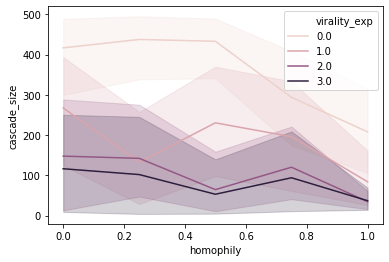

In [29]:
df_synth_plot = pd.DataFrame({'cascade_size': cascade_sizes, 'virality_exp': viralities, 'homophily': homophilies})
sb.lineplot(data=df_synth_plot, x='homophily', y='cascade_size', hue='virality_exp')

# Eigenvectors

In [30]:
from numpy import linalg as LA

In [35]:
w, v = LA.eig(A_prime)

In [52]:
print(np.array(A_prime).shape)
print(len(v))
#print(np.array(A_prime)[0])
for e_vec in v:
    print(np.sum(e_vec))
print(w)

(500, 500)
500
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

In [57]:
w, v = LA.eig([[0,0,1], [1,0,1],[0,0,1]])
print(w)

[0. 0. 1.]


## Scatter plot

In [18]:
cascade_sizes = [x for x in cascade_sizes if x !=0 ]
print(np.mean(cascade_sizes))
print(cascade_sizes)

888.4615384615385
[22, 24, 1285, 43, 28, 1096, 3265, 13, 1097, 2347, 1110, 10, 1210]


In [19]:
df = pd.DataFrame({'time': times, 'item': items, 'node': nodes}).sort_values(['time', 'item', 'node']).reset_index(drop=True)
df.set_index('time')
display(df.head())

,time,item,node
0,0,0,493
1,0,0,573
2,0,0,628
3,0,0,686
4,0,0,713


In [485]:
len_long_paths = []
cascade_sizes = []

for dag in tqdm_notebook(generate_dags(G, df)):
    len_path = len_path_dag(dag)
    if not np.isnan(len_path):
        len_long_paths.append(len_path)
        cascade_sizes.append(dag.number_of_nodes())

/Users/Cinus/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


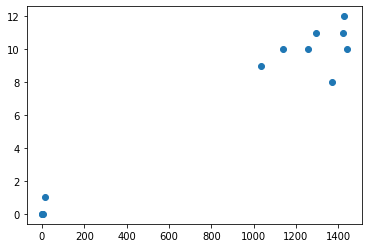

In [486]:
plt.scatter(cascade_sizes, len_long_paths)

In [489]:
# eigenvalues
from numpy import linalg as LA
w, v = LA.eig(A_prime)

In [494]:
w[i].real >

1.0

# ----------------------------------------------------------------------------------

#for node in G.nodes:
#weight = f3(np.dot(W[node]/np.linalg.norm(W[node]), gammas[0]+gn_strh*(np.ones(topics))))
weight = f3(np.dot(W[node], gammas[0]+gn_strh*(np.ones(topics))))
weights.append(weight)

fig, ax = plt.subplots(1)
print(len(weights))
ax.set_title('mean '+str(round(np.mean(weights),2))+ ', H '+str(H))
#ax.set_xlim(0, 1)
#ax.set_ylim(0, 250)
ax.set_xlabel('scalar product with item distrib')
ax.set_ylabel('freq')
ax.grid(linestyle='-', linewidth=0.2)
ax.hist(weights, bins=30) 